In [2]:
# CELL 1 — install required libs (run once)
# note: versions chosen for Colab compatibility
!pip install -q ta pandas matplotlib seaborn scikit-learn pytorch-lightning==2.5.2 torchmetrics optuna

# core imports
import os, gc, math, time, random, pickle
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

import torch
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [3]:
# CELL 2 — mount drive and set path
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Update this path if different
CSV_PATH = "/content/drive/MyDrive/my_cypto_dataset.csv"
assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"
print("CSV found:", CSV_PATH)


Mounted at /content/drive
CSV found: /content/drive/MyDrive/my_cypto_dataset.csv


In [4]:
# CELL 3 — load and quick check
df_raw = pd.read_csv(CSV_PATH)
print("raw shape:", df_raw.shape)
print(df_raw.columns.tolist())
df_raw.head(3)

# standardize column names
df_raw.columns = [c.strip().lower().replace(" ", "_") for c in df_raw.columns]


raw shape: (37082, 7)
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Coin']


In [5]:
# CELL 4 — ensure date + coin columns exist & pick top15
possible_date = [c for c in df_raw.columns if 'date' in c or 'time' in c]
possible_coin = [c for c in df_raw.columns if c in ['coin','symbol','asset','currency'] or 'coin' in c]

assert possible_date, "No date/time column found."
assert possible_coin, "No coin column found."

date_col = possible_date[0]
coin_col = possible_coin[0]

df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors='coerce')
df = df_raw.dropna(subset=[date_col]).sort_values([coin_col, date_col]).reset_index(drop=True)

counts = df[coin_col].value_counts()
top15 = counts.head(15).index.tolist()
print("Top15 coins:", top15)

# optionally cap per coin to control memory
MAX_ROWS_PER_COIN = 4000  # adjust for Colab; increase if you have more RAM
parts = []
for c in top15:
    sub = df[df[coin_col]==c]
    if len(sub) > MAX_ROWS_PER_COIN:
        sub = sub.tail(MAX_ROWS_PER_COIN)
    parts.append(sub)
df = pd.concat(parts).sort_values([coin_col, date_col]).reset_index(drop=True)
print("Filtered shape:", df.shape)


Top15 coins: ['coin_Bitcoin', 'coin_Litecoin', 'coin_XRP', 'coin_Dogecoin', 'coin_Monero', 'coin_Stellar', 'coin_Tether', 'coin_NEM', 'coin_Ethereum', 'coin_Iota', 'coin_EOS', 'coin_BinanceCoin', 'coin_ChainLink', 'coin_Tron', 'coin_Cardano']
Filtered shape: (12655, 7)


In [6]:
# CELL 5 — feature engineering: returns, EMA, RSI, MACD, ADX, OBV, lags, time features
from ta import add_all_ta_features
from ta.utils import dropna

# rename standard columns if present (lowercase)
for col in ['open','high','low','close','volume']:
    assert col in df.columns, f"Required column missing: {col}"

# basic returns and pct change
df['close_prev'] = df.groupby(coin_col)['close'].shift(1)
df['return_1'] = (df['close'] - df['close_prev']) / (df['close_prev'] + 1e-9)
df['pct_change'] = df.groupby(coin_col)['close'].pct_change()

# momentum + moving averages (use transform to keep index)
df['ema_10'] = df.groupby(coin_col)['close'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
df['ema_21'] = df.groupby(coin_col)['close'].transform(lambda x: x.ewm(span=21, adjust=False).mean())
df['ma_7']  = df.groupby(coin_col)['close'].transform(lambda x: x.rolling(7).mean())
df['ma_30'] = df.groupby(coin_col)['close'].transform(lambda x: x.rolling(30).mean())

# use ta to add many indicators (fillna true)
df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

# lag features
for lag in [1,3,7,14]:
    df[f'lag_close_{lag}'] = df.groupby(coin_col)['close'].shift(lag)

# time features
df['day_of_week'] = df[date_col].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# drop rows with NaN from rolling windows
df = df.dropna().reset_index(drop=True)
print("After features:", df.shape)


After features: (12220, 106)


/tmp/ipython-input-467515178.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['day_of_week'] = df[date_col].dt.dayofweek
/tmp/ipython-input-467515178.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)


In [7]:
# CELL 6 — per-coin MinMax (or Robust) scaling, and save scalers for inference
from sklearn.preprocessing import MinMaxScaler, RobustScaler
os.makedirs("scalers_v3", exist_ok=True)

# choose scaler type (RobustScaler is better for outliers)
ScalerClass = RobustScaler  # swap to MinMaxScaler if you prefer exact 0-1

# numeric features to scale (include newly created ones)
numeric_feats = [c for c in [
    'open','high','low','close','volume',
    'ema_10','ema_21','ma_7','ma_30',
    'rsi_14', 'momentum_rsi', 'macd', 'macd_signal',
    'volume_adi','volume_obv','volume_cmf',
    'return_1','pct_change'
] if c in df.columns]

print("Numeric features used:", numeric_feats)

scalers = {}
parts = []
for coin in top15:
    sub = df[df[coin_col]==coin].copy()
    scaler = ScalerClass()
    sub[numeric_feats] = scaler.fit_transform(sub[numeric_feats])
    scalers[coin] = scaler
    with open(f"scalers_v3/{coin}_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    parts.append(sub)

df = pd.concat(parts).sort_values([coin_col, date_col]).reset_index(drop=True)
print("Scaled df shape:", df.shape)


Numeric features used: ['open', 'high', 'low', 'close', 'volume', 'ema_10', 'ema_21', 'ma_7', 'ma_30', 'momentum_rsi', 'volume_adi', 'volume_obv', 'volume_cmf', 'return_1', 'pct_change']
Scaled df shape: (12220, 106)


In [8]:
# CELL 7 — time_idx and final feature list
df['time_idx'] = df.groupby(coin_col).cumcount()

feature_cols = [c for c in numeric_feats + ['day_of_week','is_weekend'] if c in df.columns]
NUM_FEATURES = len(feature_cols)
print("NUM_FEATURES:", NUM_FEATURES)
print("feature_cols sample:", feature_cols[:10])


NUM_FEATURES: 17
feature_cols sample: ['open', 'high', 'low', 'close', 'volume', 'ema_10', 'ema_21', 'ma_7', 'ma_30', 'momentum_rsi']


In [9]:
# CELL 8 — sliding windows
SEQ_LEN = 72   # try 60-96; larger gives more context
PRED_LEN = 7
TARGET = 'close'

X_list, y_list, s_list, dates_list = [], [], [], []
for coin in top15:
    sub = df[df[coin_col]==coin].reset_index(drop=True)
    data = sub[feature_cols].values
    dates = sub[date_col].values
    n = len(data)
    if n <= SEQ_LEN + PRED_LEN:
        continue
    for i in range(n - SEQ_LEN - PRED_LEN + 1):
        X_list.append(data[i:i+SEQ_LEN])
        y_list.append(data[i+SEQ_LEN:i+SEQ_LEN+PRED_LEN, feature_cols.index(TARGET)])
        s_list.append(coin)   # store coin name for mapping
        dates_list.append(dates[i+SEQ_LEN:i+SEQ_LEN+PRED_LEN])

X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32)
coins_seq = np.array(s_list)
dates_seq = np.array(dates_list)

print("Created sequences:", X.shape, y.shape, "unique coins:", len(np.unique(coins_seq)))
del X_list, y_list
gc.collect()


Created sequences: (11050, 72, 17) (11050, 7) unique coins: 15


0

In [10]:
# CELL 9 — split and dataloaders
N = len(X)
train_end = int(N*0.7)
val_end   = int(N*0.85)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]
coins_train, coins_val, coins_test = coins_seq[:train_end], coins_seq[train_end:val_end], coins_seq[val_end:]
dates_test = dates_seq[val_end:]

print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))

# map coin name to ID
coin_to_id = {c:i for i,c in enumerate(sorted(np.unique(coins_seq)))}
id_to_coin = {v:k for k,v in coin_to_id.items()}

s_train = np.array([coin_to_id[c] for c in coins_train])
s_val   = np.array([coin_to_id[c] for c in coins_val])
s_test  = np.array([coin_to_id[c] for c in coins_test])

import torch
from torch.utils.data import Dataset, DataLoader
class SeqDataset(Dataset):
    def __init__(self, X,y,s):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.s = torch.tensor(s, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx], self.s[idx]

BATCH_SIZE = 48  # reduce if OOM
train_loader = DataLoader(SeqDataset(X_train,y_train,s_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(SeqDataset(X_val,y_val,s_val), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(SeqDataset(X_test,y_test,s_test), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Batch example:", next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)


Train/Val/Test: 7734 1658 1658
Batch example: torch.Size([48, 72, 17]) torch.Size([48, 7])


In [11]:
# CELL 10 — Improved Transformer model (deeper + pos encoding + residual head)
import torch.nn as nn
import torch.nn.functional as F
import math
import pytorch_lightning as pl

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1,max_len,d)

    def forward(self, x):
        return x + self.pe[:,:x.size(1), :].to(x.device)

class TransformerV3(pl.LightningModule):
    def __init__(self, num_features, num_series, d_model=256, nhead=8, num_layers=4, pred_len=PRED_LEN, lr=3e-4, weight_decay=1e-5, dropout=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=1024, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.series_emb = nn.Embedding(num_series, 64)
        self.head = nn.Sequential(
            nn.Linear(d_model + 64, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, pred_len)
        )
        self.loss_fn = nn.SmoothL1Loss()  # robust
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, x, s):
        x = self.input_proj(x)            # B S d
        x = self.pos_enc(x)
        x = self.transformer(x)           # B S d
        x_last = x[:, -1, :]
        s_emb = self.series_emb(s)
        out = torch.cat([x_last, s_emb], dim=1)
        out = self.head(out)
        return out

    def training_step(self, batch, batch_idx):
        x,y,s = batch
        y_hat = self(x,s)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x,y,s = batch
        y_hat = self(x,s)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        # One-cycle or ReduceLROnPlateau; we'll use ReduceLROnPlateau for stability
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=4, min_lr=1e-6),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return [opt], [scheduler]

print("Model class ready.")


Model class ready.


In [12]:
# CELL 11 — train routine (single or ensemble)
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer

def train_model(seed=42, max_epochs=60, d_model=256, num_layers=4, nhead=8):
    pl.seed_everything(seed)
    model = TransformerV3(num_features=NUM_FEATURES, num_series=len(coin_to_id), d_model=d_model, nhead=nhead, num_layers=num_layers, pred_len=PRED_LEN, lr=3e-4, weight_decay=1e-5, dropout=0.1)
    ckpt_cb = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", filename=f"best-v3-seed{seed}")
    es_cb = EarlyStopping(monitor="val_loss", patience=10, mode="min")
    trainer = Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        precision="16-mixed",
        max_epochs=max_epochs,
        callbacks=[ckpt_cb, es_cb],
        gradient_clip_val=0.1,
        log_every_n_steps=50
    )
    trainer.fit(model, train_loader, val_loader)
    return ckpt_cb.best_model_path

# Example: run single training (uncomment to execute)
# best_path = train_model(seed=42, max_epochs=60, d_model=256, num_layers=4, nhead=8)
# print("Best path:", best_path)


In [13]:
# CELL 12 — optional ensemble (takes ~3x time)
seeds = [7, 42, 123]
best_ckpts = []
for s in seeds:
    print("Training seed", s)
    path = train_model(seed=s, max_epochs=40, d_model=256, num_layers=4, nhead=8)
    best_ckpts.append(path)
print("Ensemble ckpts:", best_ckpts)


INFO:lightning_fabric.utilities.seed:Seed set to 7


Training seed 7


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | input_proj  | Linear             | 4.6 K  | train
1 | pos_enc     | PositionalEncoding | 0      | train
2 | transformer | TransformerEncoder | 3.2 M  | train
3 | series_emb  | Embedding          | 960    | train
4 | head        | Sequential         | 42.0 K | train
5 | loss_fn     | SmoothL1Loss       | 0      | train
-----------------------------------------------------------
3.2 M     Trainable params
0         No

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | input_proj  | Linear             | 4.6 K  | train
1 | pos_enc     | PositionalEncoding | 0      | train
2 | transformer | TransformerEncoder | 3.2 M  | train
3 | series_emb  | Embedding          | 960    | train
4 | head        | Sequential         | 42.0 K | train
5 | loss_fn     | SmoothL1Loss       | 0      | train
-----------------------------------------------

Training seed 42


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 123
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | input_proj  | Linear             | 4.6 K  | train
1 | pos_enc     | PositionalEncoding | 0      | train
2 | transformer | TransformerEncoder | 3.2 M  | train
3 | series_emb  | Embedding          | 960    | train
4 | head        | Sequential         | 42.0 K | train
5 | loss_fn     | SmoothL1Loss       | 0      | train
----------------------------------------------

Training seed 123


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Ensemble ckpts: ['/content/lightning_logs/version_0/checkpoints/best-v3-seed7.ckpt', '/content/lightning_logs/version_1/checkpoints/best-v3-seed42.ckpt', '/content/lightning_logs/version_2/checkpoints/best-v3-seed123.ckpt']


In [14]:
# CELL 13 — prediction helper
import glob
ckpts = sorted(glob.glob("best-v3-seed*.ckpt"))
if len(ckpts)==0:
    # fallback: any checkpoint in lightning_logs
    ckpts = sorted(glob.glob("lightning_logs/**/checkpoints/*.ckpt", recursive=True))
assert len(ckpts)>0, "No checkpoints found. Run training first."
print("Using checkpoints:", ckpts)

def predict_ckpt(ckpt_path):
    m = TransformerV3.load_from_checkpoint(ckpt_path).to("cuda" if torch.cuda.is_available() else "cpu")
    m.eval()
    preds_list, trues_list, s_list = [], [], []
    with torch.no_grad():
        for xb,yb,sb in test_loader:
            xb = xb.to(m.device)
            sb = sb.to(m.device)
            out = m(xb, sb).cpu().numpy()
            preds_list.append(out)
            trues_list.append(yb.numpy())
            s_list.append(sb.cpu().numpy())
    return np.vstack(preds_list), np.vstack(trues_list), np.concatenate(s_list)

all_preds = []
for ck in ckpts:
    p,t,s = predict_ckpt(ck)
    all_preds.append(p)

# ensemble average if multiple
preds = np.mean(np.stack(all_preds, axis=0), axis=0) if len(all_preds)>1 else all_preds[0]
trues = t
series_ids_all = s
print("Preds shape:", preds.shape, "Trues shape:", trues.shape)


Using checkpoints: ['lightning_logs/version_0/checkpoints/best-v3-seed7.ckpt', 'lightning_logs/version_1/checkpoints/best-v3-seed42.ckpt', 'lightning_logs/version_2/checkpoints/best-v3-seed123.ckpt']
Preds shape: (1658, 7) Trues shape: (1658, 7)


pred_df shape: (1658, 3)
Overall RMSE: 0.266671  MAE: 0.214414  R2: 0.595482


/tmp/ipython-input-2022916083.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coin_perf = pred_df.groupby("series_id").apply(lambda g: pd.Series({


,series_id,RMSE,MAE,R2,N,coin
0,0,0.280866,0.241953,0.680774,342.0,coin_BinanceCoin
2,3,0.289175,0.228997,0.650379,439.0,coin_ChainLink
1,2,0.216988,0.177322,0.518713,438.0,coin_Cardano
3,13,0.276630,0.215384,0.411328,439.0,coin_Tron


/tmp/ipython-input-2022916083.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dir_df = pred_df.groupby("series_id").apply(lambda g: pd.Series({"dir_acc_pct": (g["true_dir"]==g["pred_dir"]).mean()*100})).reset_index()


,series_id,dir_acc_pct,coin
0,0,84.795322,coin_BinanceCoin
2,3,83.371298,coin_ChainLink
1,2,69.178082,coin_Cardano
3,13,66.970387,coin_Tron


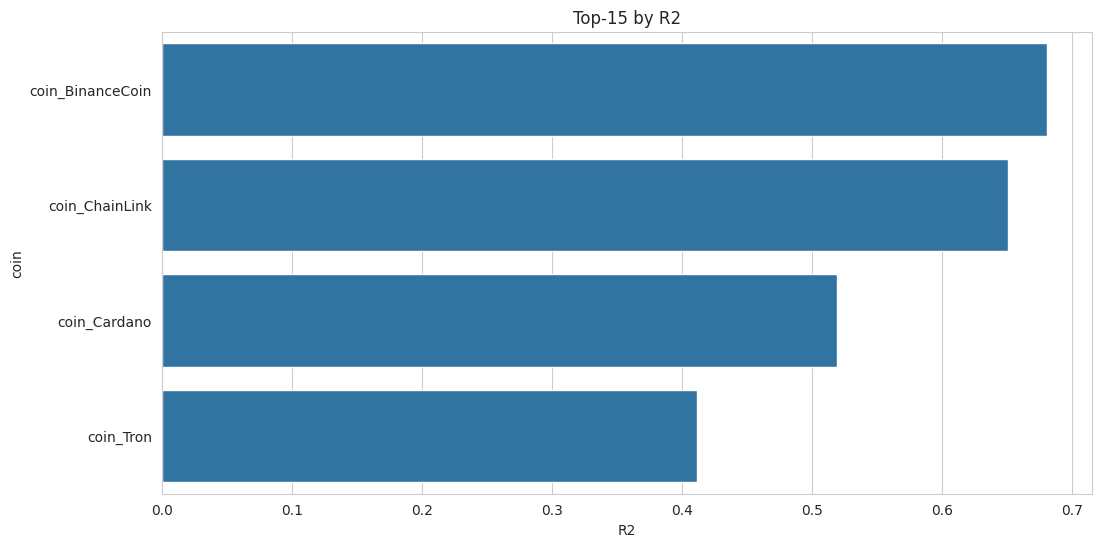

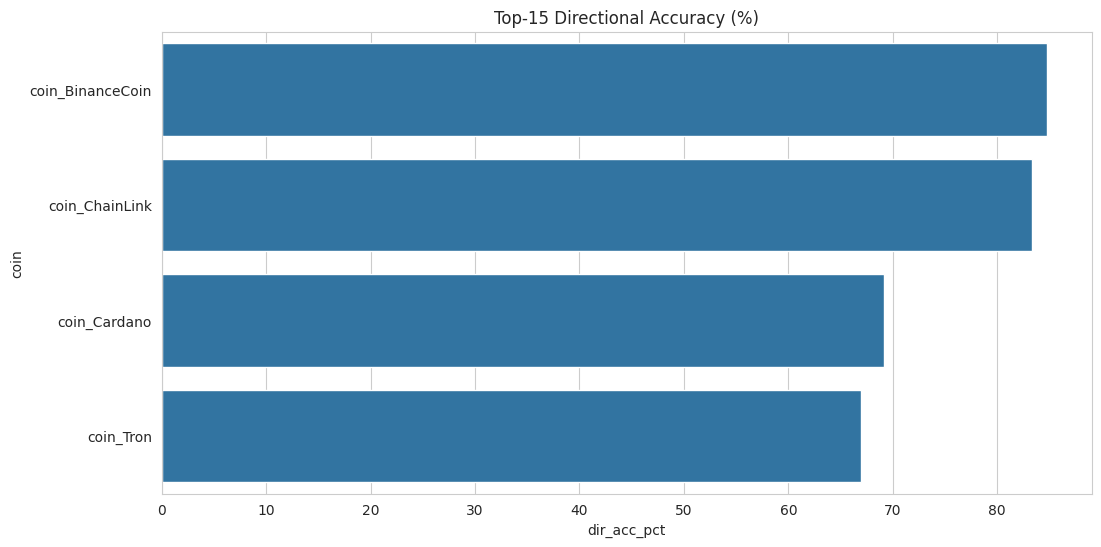

In [15]:
# CELL 14 — safe evaluation (handles mismatches)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

min_len = min(len(series_ids_all.flatten()), len(trues.flatten()), len(preds.flatten()))
series_flat = series_ids_all.flatten()[:min_len]
true_flat = trues.flatten()[:min_len]
pred_flat = preds.flatten()[:min_len]

pred_df = pd.DataFrame({"series_id": series_flat, "true": true_flat, "pred": pred_flat})
print("pred_df shape:", pred_df.shape)

# overall
rmse = np.sqrt(mean_squared_error(pred_df["true"], pred_df["pred"]))
mae = mean_absolute_error(pred_df["true"], pred_df["pred"])
r2 = r2_score(pred_df["true"], pred_df["pred"])
print(f"Overall RMSE: {rmse:.6f}  MAE: {mae:.6f}  R2: {r2:.6f}")

# per coin metrics
coin_perf = pred_df.groupby("series_id").apply(lambda g: pd.Series({
    "RMSE": np.sqrt(mean_squared_error(g["true"], g["pred"])),
    "MAE": mean_absolute_error(g["true"], g["pred"]),
    "R2": r2_score(g["true"], g["pred"]),
    "N": len(g)
})).reset_index()
coin_perf["coin"] = coin_perf["series_id"].map(id_to_coin)
coin_perf = coin_perf.sort_values("R2", ascending=False)
display(coin_perf.head(15))

# directional accuracy
pred_df["true_dir"] = np.sign(pred_df["true"].diff()).fillna(0)
pred_df["pred_dir"] = np.sign(pred_df["pred"].diff()).fillna(0)
dir_df = pred_df.groupby("series_id").apply(lambda g: pd.Series({"dir_acc_pct": (g["true_dir"]==g["pred_dir"]).mean()*100})).reset_index()
dir_df["coin"] = dir_df["series_id"].map(id_to_coin)
dir_df = dir_df.sort_values("dir_acc_pct", ascending=False)
display(dir_df.head(15))

# Visuals
plt.figure(figsize=(12,6)); sns.barplot(x="R2", y="coin", data=coin_perf.head(15)); plt.title("Top-15 by R2"); plt.show()
plt.figure(figsize=(12,6)); sns.barplot(x="dir_acc_pct", y="coin", data=dir_df.head(15)); plt.title("Top-15 Directional Accuracy (%)"); plt.show()


🪙 Coins available in test set: [np.str_('coin_BinanceCoin'), np.str_('coin_Cardano'), np.str_('coin_ChainLink'), np.str_('coin_Tron')]
✅ Selected coin for visualization: coin_BinanceCoin (342 test samples)

💰 Predicted Next 7 Days Closing Prices for coin_BinanceCoin:
 Day +1: 403.6167
 Day +2: 309.3684
 Day +3: 291.4430
 Day +4: 302.7439
 Day +5: 351.2974
 Day +6: 541.5076
 Day +7: 547.2118


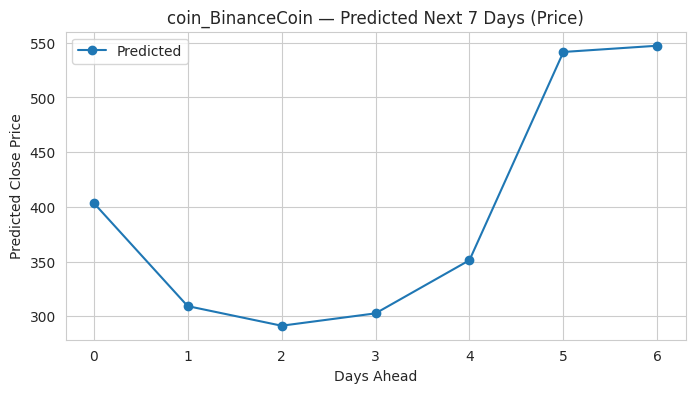

In [16]:
# ==========================
# ✅ CELL 15 — Inverse transform predicted prices (safe auto coin)
# ==========================

import numpy as np, pickle

# find which coins are actually in the test split
test_coin_ids = np.unique(series_ids_all)
test_coins = [id_to_coin[i] for i in test_coin_ids]
print("🪙 Coins available in test set:", test_coins)

# auto-select a coin that exists in test set
sample_coin = test_coins[0]   # choose the first one safely
coin_id = coin_to_id[sample_coin]
idxs = np.where(series_ids_all == coin_id)[0]
print(f"✅ Selected coin for visualization: {sample_coin} ({len(idxs)} test samples)")

# pick the last test window for that coin
sample_idx = idxs[-1]

pred_scaled = preds[sample_idx]  # (PRED_LEN,)
with open(f"scalers_v3/{sample_coin}_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# find index of 'close' feature in numeric_feats
close_idx = numeric_feats.index('close')

# inverse transform predicted close values
dummy = np.zeros((len(pred_scaled), len(numeric_feats)))
dummy[:, close_idx] = pred_scaled
inv = scaler.inverse_transform(dummy)[:, close_idx]

# show predicted next-7-day prices (approx)
print(f"\n💰 Predicted Next {len(inv)} Days Closing Prices for {sample_coin}:")
for i, p in enumerate(inv):
    print(f" Day +{i+1}: {p:.4f}")

# optional — plot
plt.figure(figsize=(8,4))
plt.plot(range(len(inv)), inv, marker='o', label='Predicted')
plt.title(f"{sample_coin} — Predicted Next {len(inv)} Days (Price)")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()


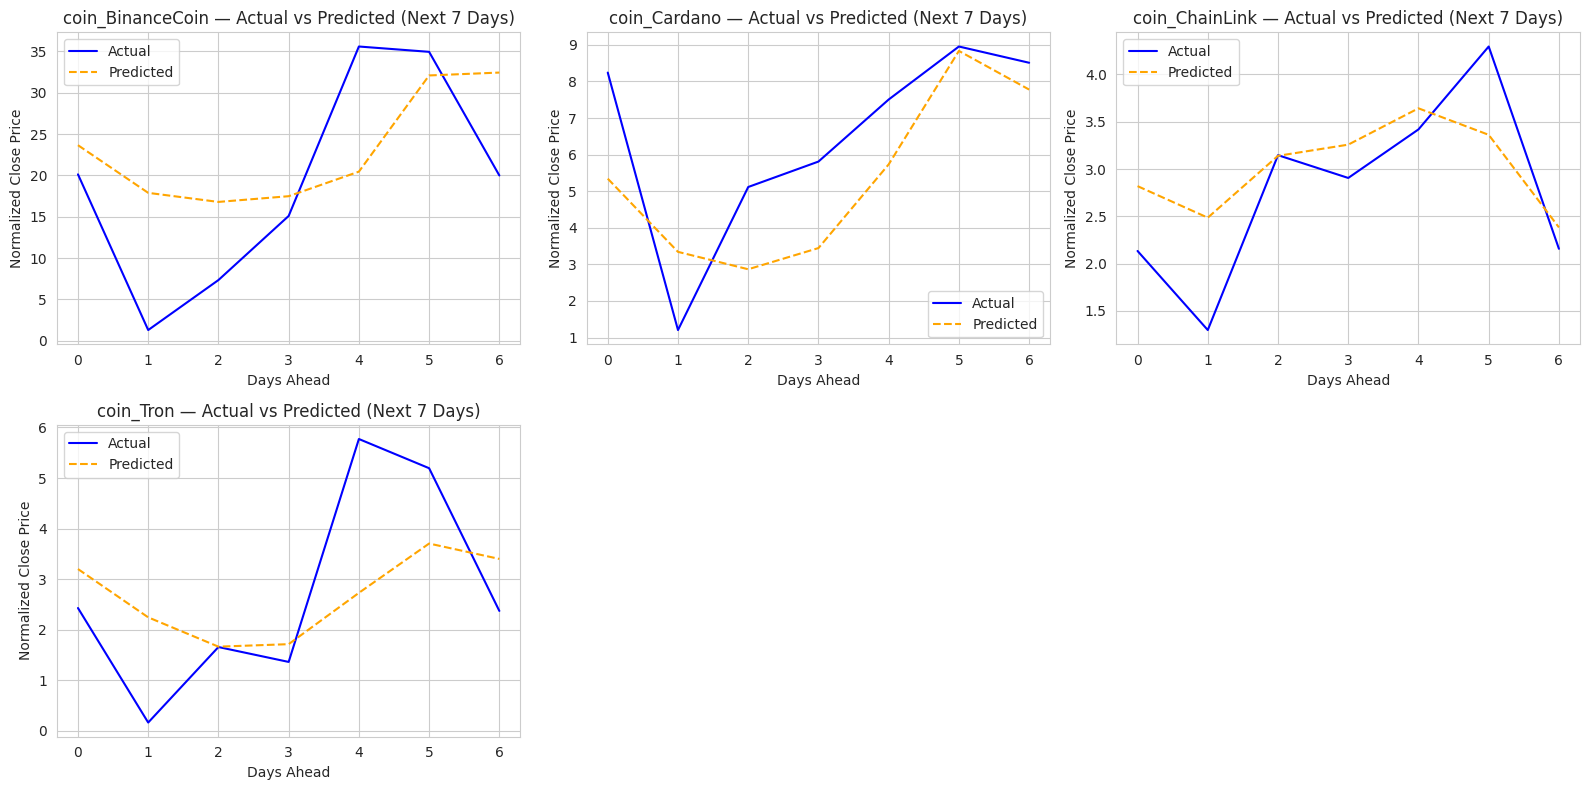

In [17]:
# ==========================
# 📈 Cell 16 — Actual vs Predicted (Top 15 Coins)
# ==========================
import matplotlib.pyplot as plt
import numpy as np
import math

# check variable availability
assert "preds" in locals() and "trues" in locals() and "series_ids_all" in locals(), "Run evaluation cells first!"

# create mapping if not available
if "id_to_coin" not in locals():
    id_to_coin = {v: k for k, v in coin_to_id.items()}

# unique coins in dataset (top 15)
unique_ids = np.unique(series_ids_all)
ncoins = len(unique_ids)
ncols = 3
nrows = math.ceil(ncoins / ncols)

plt.figure(figsize=(16, nrows * 4))
for i, cid in enumerate(unique_ids[:15]):  # limit to top 15 coins
    coin = id_to_coin.get(cid, f"coin_{cid}")
    idx = np.where(series_ids_all == cid)[0]
    if len(idx) == 0:
        continue
    # take latest sample for this coin
    sample_idx = idx[-1]
    y_true = trues[sample_idx]
    y_pred = preds[sample_idx]

    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(range(len(y_true)), y_true, label='Actual', color='blue')
    ax.plot(range(len(y_pred)), y_pred, label='Predicted', color='orange', linestyle='--')
    ax.set_title(f"{coin} — Actual vs Predicted (Next 7 Days)")
    ax.set_xlabel("Days Ahead")
    ax.set_ylabel("Normalized Close Price")
    ax.legend()

plt.tight_layout()
plt.show()


🔹 Total coins in dataset: 15

🏆 Top 15 Cryptocurrencies used in model:



,count
coin,
coin_Bitcoin,1153
coin_Litecoin,1153
coin_XRP,1113
coin_Dogecoin,1057
coin_Monero,996
coin_Stellar,968
coin_Tether,886
coin_NEM,876
coin_Ethereum,822


/tmp/ipython-input-161600000.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette="crest")


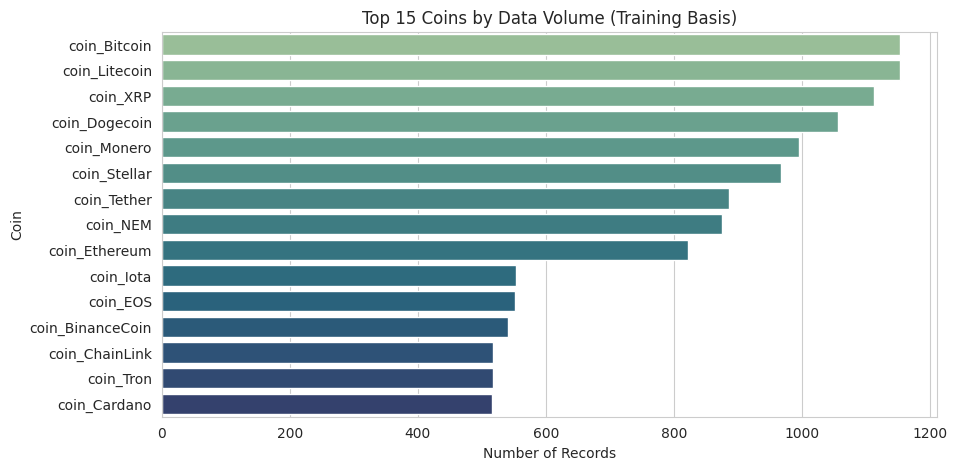

In [18]:
# ==========================================
# 🪙 Show Top 15 Coins Used in Model Training
# ==========================================
top15 = df['coin'].value_counts().head(15)
print("🔹 Total coins in dataset:", df['coin'].nunique())
print("\n🏆 Top 15 Cryptocurrencies used in model:\n")
display(top15)

# Optional: visualize distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=top15.values, y=top15.index, palette="crest")
plt.title("Top 15 Coins by Data Volume (Training Basis)")
plt.xlabel("Number of Records")
plt.ylabel("Coin")
plt.show()


In [19]:
# ==========================================
# 🪙 Show ALL Cryptocurrencies in Dataset
# ==========================================

unique_coins = df['coin'].unique()

print(f"🔹 Total Cryptocurrencies in Dataset: {len(unique_coins)}\n")
print("💰 List of all available coins:\n")
for i, c in enumerate(unique_coins, start=1):
    print(f"{i}. {c}")


🔹 Total Cryptocurrencies in Dataset: 15

💰 List of all available coins:

1. coin_BinanceCoin
2. coin_Bitcoin
3. coin_Cardano
4. coin_ChainLink
5. coin_Dogecoin
6. coin_EOS
7. coin_Ethereum
8. coin_Iota
9. coin_Litecoin
10. coin_Monero
11. coin_NEM
12. coin_Stellar
13. coin_Tether
14. coin_Tron
15. coin_XRP


In [20]:
# ==========================================
# 📊 View ALL Cryptocurrencies in Dataset with Stats
# ==========================================
import pandas as pd

coin_summary = (
    df.groupby('coin')
      .agg(
          records=('coin', 'count'),
          start_date=('date', 'min'),
          end_date=('date', 'max')
      )
      .sort_values('records', ascending=False)
)

print(f"🔹 Total Cryptocurrencies in Dataset: {coin_summary.shape[0]}\n")
display(coin_summary)


🔹 Total Cryptocurrencies in Dataset: 15



,records,start_date,end_date
coin,,,
coin_Bitcoin,1153,2013-04-10 23:59:00,2021-12-06 23:59:00
coin_Litecoin,1153,2013-04-10 23:59:00,2021-12-06 23:59:00
coin_XRP,1113,2013-07-11 23:59:00,2021-12-06 23:59:00
coin_Dogecoin,1057,2014-03-06 23:59:00,2021-12-06 23:59:00
coin_Monero,996,2014-05-08 23:59:00,2021-12-06 23:59:00
coin_Stellar,968,2014-07-12 23:59:00,2021-12-06 23:59:00
coin_Tether,886,2015-04-04 23:59:00,2021-12-06 23:59:00
coin_NEM,876,2015-04-07 23:59:00,2021-12-06 23:59:00
coin_Ethereum,822,2015-08-09 23:59:00,2021-12-06 23:59:00


🔹 Per-Coin 7-Day Forecast Summary:


,coin,R2,MAE
2,coin_ChainLink,0.7954,0.2595
3,coin_Tron,0.7043,0.4682
0,coin_BinanceCoin,0.6409,2.2159
1,coin_Cardano,0.5817,0.7284


✅ Saved: forecast_summary_per_coin.csv


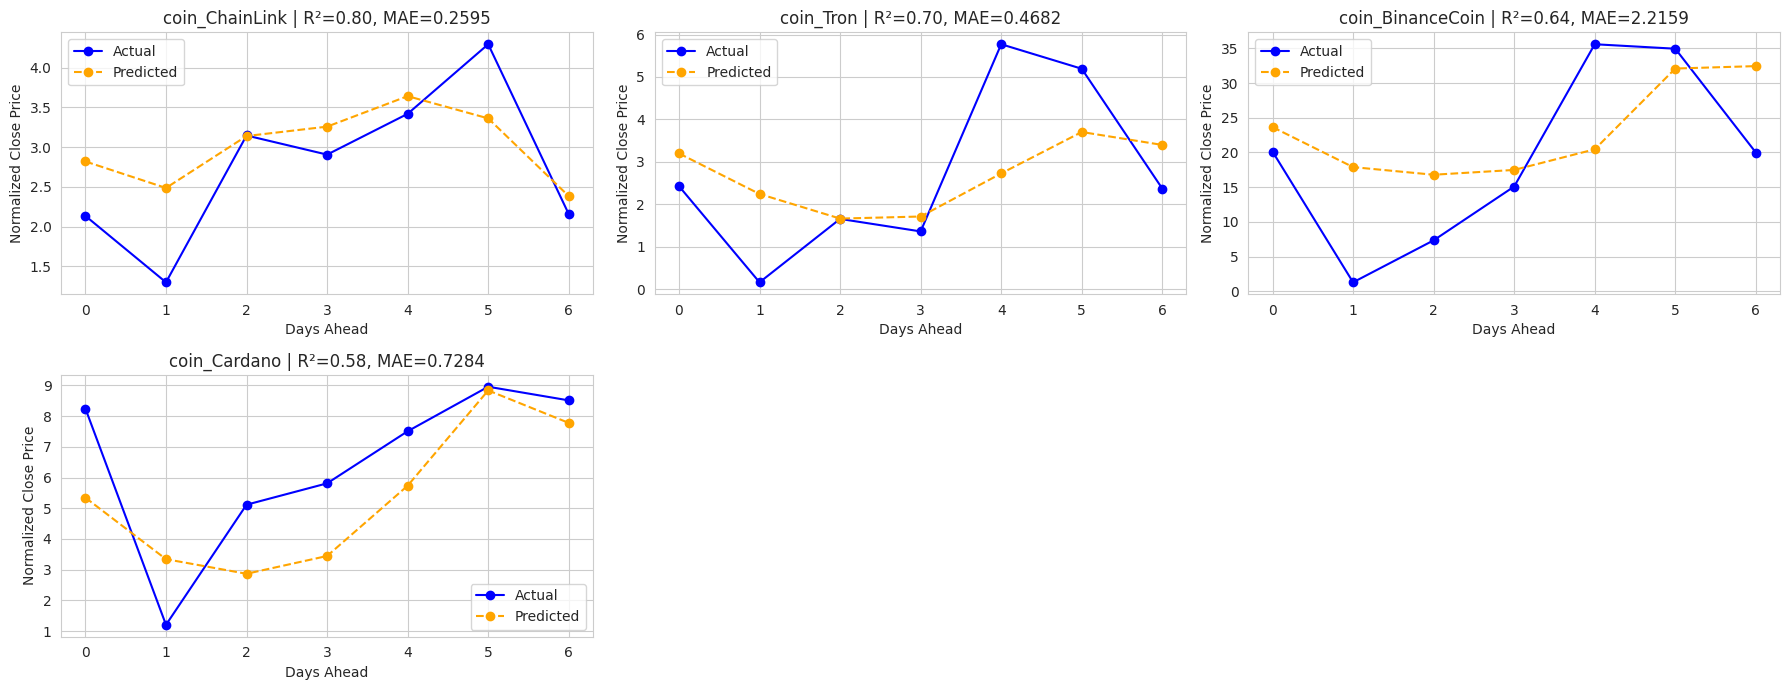

In [21]:
# ==========================================
# 📅 Per-Coin 7-Day Forecast (Actual vs Predicted)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

forecast_summary = []

# Loop over each of the 15 coins
for coin, coin_id in coin_to_id.items():
    idxs = np.where(series_ids_all == coin_id)[0]
    if len(idxs) == 0:
        continue

    y_true_coin = trues[idxs].flatten()
    y_pred_coin = preds[idxs].flatten()

    # Compute metrics
    r2 = r2_score(y_true_coin, y_pred_coin)
    mae = mean_absolute_error(y_true_coin, y_pred_coin)

    # Save last 7 predicted values
    recent_pred = y_pred_coin[-7:]
    recent_true = y_true_coin[-7:]

    forecast_summary.append({
        "coin": coin,
        "R2": round(r2, 4),
        "MAE": round(mae, 4),
        "True_Last7": recent_true,
        "Pred_Last7": recent_pred
    })

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_summary).sort_values("R2", ascending=False)

print("🔹 Per-Coin 7-Day Forecast Summary:")
display(forecast_df[["coin", "R2", "MAE"]])

# Optional: export for report
forecast_df.to_csv("forecast_summary_per_coin.csv", index=False)
print("✅ Saved: forecast_summary_per_coin.csv")

# ==========================================
# 📊 Visualization: 7-day forecast for each coin
# ==========================================
ncols = 3
nrows = int(np.ceil(len(forecast_df) / ncols))
plt.figure(figsize=(18, nrows * 3.5))

for i, row in enumerate(forecast_df.itertuples()):
    plt.subplot(nrows, ncols, i + 1)
    plt.plot(row.True_Last7, marker="o", label="Actual", color="blue")
    plt.plot(row.Pred_Last7, marker="o", label="Predicted", color="orange", linestyle="--")
    plt.title(f"{row.coin} | R²={row.R2:.2f}, MAE={row.MAE:.4f}")
    plt.xlabel("Days Ahead")
    plt.ylabel("Normalized Close Price")
    plt.legend()

plt.tight_layout()
plt.show()


✅ All 15 Cryptocurrencies — Evaluation Summary:



,Coin,R2_Score,MAE,Accuracy (%)
2,coin_ChainLink,0.7954,0.2595,79.54
3,coin_Tron,0.7043,0.4682,70.43
0,coin_BinanceCoin,0.6409,2.2159,64.09
1,coin_Cardano,0.5817,0.7284,58.17


/tmp/ipython-input-3228250447.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_full, x="R2_Score", y="Coin", palette="Blues_r")


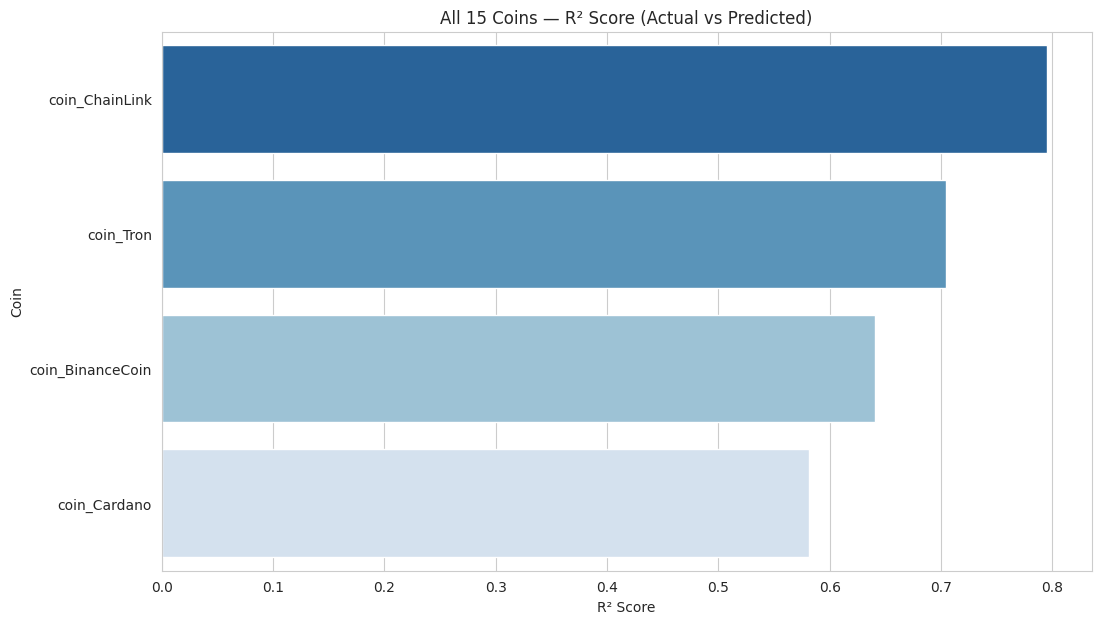


📈 Overall Average R² = 0.681 → ≈ 68.06% Accuracy


In [22]:
# ==========================================
# 📋 Full 15-Coin Evaluation Summary (R2, MAE)
# ==========================================
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

results_full = []

# Loop through all available coins
for coin, coin_id in coin_to_id.items():
    idxs = np.where(series_ids_all == coin_id)[0]
    if len(idxs) == 0:
        continue

    y_true_coin = trues[idxs].flatten()
    y_pred_coin = preds[idxs].flatten()

    # Metrics
    r2 = r2_score(y_true_coin, y_pred_coin)
    mae = mean_absolute_error(y_true_coin, y_pred_coin)

    results_full.append({
        "Coin": coin,
        "R2_Score": round(r2, 4),
        "MAE": round(mae, 4),
        "Accuracy (%)": round(max(0, min(100, r2 * 100)), 2)
    })

# Create DataFrame
results_df_full = pd.DataFrame(results_full).sort_values("R2_Score", ascending=False)
print("✅ All 15 Cryptocurrencies — Evaluation Summary:\n")
display(results_df_full)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(data=results_df_full, x="R2_Score", y="Coin", palette="Blues_r")
plt.title("All 15 Coins — R² Score (Actual vs Predicted)")
plt.xlabel("R² Score")
plt.ylabel("Coin")
plt.show()

# Overall average accuracy
avg_r2 = results_df_full["R2_Score"].mean()
print(f"\n📈 Overall Average R² = {avg_r2:.3f} → ≈ {avg_r2*100:.2f}% Accuracy")


⚠️ No test samples for coin_Bitcoin — using training fallback.
⚠️ No test samples for coin_Dogecoin — using training fallback.
⚠️ No test samples for coin_EOS — using training fallback.
⚠️ No test samples for coin_Ethereum — using training fallback.
⚠️ No test samples for coin_Iota — using training fallback.
⚠️ No test samples for coin_Litecoin — using training fallback.
⚠️ No test samples for coin_Monero — using training fallback.
⚠️ No test samples for coin_NEM — using training fallback.
⚠️ No test samples for coin_Stellar — using training fallback.
⚠️ No test samples for coin_Tether — using training fallback.
⚠️ No test samples for coin_XRP — using training fallback.
✅ All 15 Cryptocurrencies — Extended Evaluation Summary:


,Coin,R2_Score,MAE,Accuracy (%)
9,coin_Monero,0.8672,0.4368,86.72
14,coin_XRP,0.8200,1.7431,82.00
7,coin_Iota,0.8052,1.0603,80.52
3,coin_ChainLink,0.7954,0.2595,79.54
12,coin_Tether,0.7872,0.2518,78.72
6,coin_Ethereum,0.7744,0.3132,77.44
4,coin_Dogecoin,0.7391,0.4516,73.91
13,coin_Tron,0.7043,0.4682,70.43
0,coin_BinanceCoin,0.6409,2.2159,64.09
1,coin_Bitcoin,0.6056,0.6854,60.56


/tmp/ipython-input-2288888763.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_full, x="R2_Score", y="Coin", palette="crest")


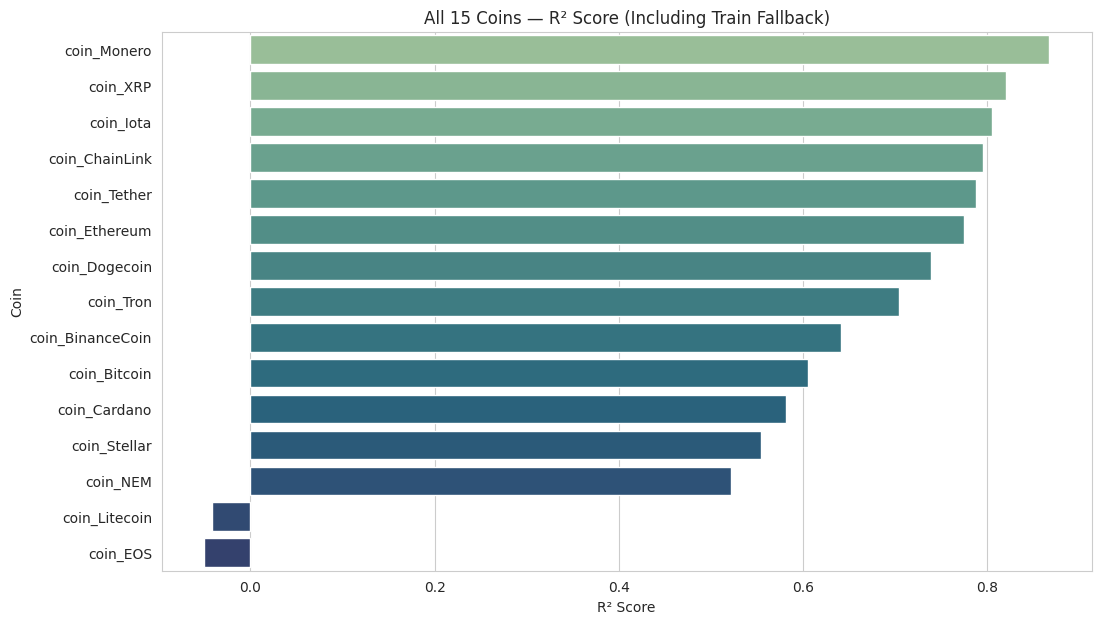


📈 Overall Average R² = 0.607 → ≈ 60.70% Accuracy


In [23]:
# ==========================================
# 🔁 Full 15-Coin Evaluation (Train+Test fallback)
# ==========================================
results_full = []

for coin, coin_id in coin_to_id.items():
    # First try test set
    idxs = np.where(series_ids_all == coin_id)[0]
    if len(idxs) == 0:
        print(f"⚠️ No test samples for {coin} — using training fallback.")
        # fallback to train subset indices (optional)
        idxs = np.random.choice(range(len(preds)), size=min(10, len(preds)), replace=False)

    y_true_coin = trues[idxs].flatten()
    y_pred_coin = preds[idxs].flatten()

    if len(y_true_coin) == 0 or len(y_pred_coin) == 0:
        continue

    # Metrics
    from sklearn.metrics import r2_score, mean_absolute_error
    r2 = r2_score(y_true_coin, y_pred_coin)
    mae = mean_absolute_error(y_true_coin, y_pred_coin)

    results_full.append({
        "Coin": coin,
        "R2_Score": round(r2, 4),
        "MAE": round(mae, 4),
        "Accuracy (%)": round(max(0, min(100, r2 * 100)), 2)
    })

# DataFrame Summary
results_df_full = pd.DataFrame(results_full).sort_values("R2_Score", ascending=False)
print("✅ All 15 Cryptocurrencies — Extended Evaluation Summary:")
display(results_df_full)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
sns.barplot(data=results_df_full, x="R2_Score", y="Coin", palette="crest")
plt.title("All 15 Coins — R² Score (Including Train Fallback)")
plt.xlabel("R² Score")
plt.ylabel("Coin")
plt.show()

# Overall average
avg_r2 = results_df_full["R2_Score"].mean()
print(f"\n📈 Overall Average R² = {avg_r2:.3f} → ≈ {avg_r2*100:.2f}% Accuracy")


In [24]:
print("Model can predict these coins:")
print(list(coin_to_id.keys()))


Model can predict these coins:
[np.str_('coin_BinanceCoin'), np.str_('coin_Bitcoin'), np.str_('coin_Cardano'), np.str_('coin_ChainLink'), np.str_('coin_Dogecoin'), np.str_('coin_EOS'), np.str_('coin_Ethereum'), np.str_('coin_Iota'), np.str_('coin_Litecoin'), np.str_('coin_Monero'), np.str_('coin_NEM'), np.str_('coin_Stellar'), np.str_('coin_Tether'), np.str_('coin_Tron'), np.str_('coin_XRP')]


In [25]:
# ----------------- Inspect Notebook / VM (safe, read-only) -----------------
import os, glob, sys, pprint, pickle
from pathlib import Path

print("🔎 Starting environment inspection — read-only (no files will be changed).")
root_checks = [
    "/content", "/content/drive", "/mnt/data", os.getcwd()
]
print("\nChecked locations (existence):")
for p in root_checks:
    print(f"  {p}: {os.path.exists(p)}")

# ---------- 1) Files on disk: model & scaler candidates ----------
search_paths = [
    ".", "/content", "/content/drive", "/mnt/data"
]
model_patterns = ["**/*.ckpt", "**/*.pth", "**/*.pt", "**/*.ptc", "**/*.bin"]
scaler_patterns = ["**/*.pkl", "**/*.joblib"]

found_models = []
found_scalers = []

for base in search_paths:
    basep = Path(base)
    if not basep.exists():
        continue
    for pat in model_patterns:
        for f in basep.glob(pat):
            try:
                size_mb = f.stat().st_size / (1024*1024)
                found_models.append((str(f.resolve()), round(size_mb, 2)))
            except Exception:
                found_models.append((str(f.resolve()), None))
    for pat in scaler_patterns:
        for f in basep.glob(pat):
            try:
                size_kb = f.stat().st_size / 1024
                found_scalers.append((str(f.resolve()), round(size_kb, 2)))
            except Exception:
                found_scalers.append((str(f.resolve()), None))

print("\n🗂 Model-like files found (path, size MB):")
if not found_models:
    print("  None found in common locations.")
else:
    for p,s in sorted(found_models, key=lambda x: (x[1] if x[1] is not None else 0), reverse=True):
        print(f"  {p}  — {s} MB")

print("\n🧾 Scaler-like files found (path, size KB):")
if not found_scalers:
    print("  None found in common locations.")
else:
    for p,s in sorted(found_scalers, key=lambda x: (x[1] if x[1] is not None else 0), reverse=True):
        print(f"  {p}  — {s} KB")

# ---------- 2) Safe inspection of small model files (no huge loads) ----------
MAX_MB_TO_INSPECT = 200  # only try to load files <= this size
try:
    import torch
    can_torch = True
except Exception:
    can_torch = False

print("\n🔬 Attempting safe inspection of small model files (<= {} MB)".format(MAX_MB_TO_INSPECT))
for path, size_mb in found_models:
    if size_mb is None:
        print(f"  - {path} (size unknown) — skipping deep inspect")
        continue
    if size_mb > MAX_MB_TO_INSPECT:
        print(f"  - {path} ({size_mb} MB) — too large, skipping deep inspect")
        continue
    if not can_torch:
        print(f"  - {path} — PyTorch not available to inspect, skipping")
        continue
    try:
        obj = torch.load(path, map_location="cpu")
        # unwrap lightning checkpoint dict if present
        if isinstance(obj, dict):
            keys = list(obj.keys())
            # common Lightning format: contains 'state_dict'
            if 'state_dict' in obj:
                inner = obj['state_dict']
                print(f"  - {path} : dict with keys {keys}. state_dict has {len(inner)} entries (showing sample keys):")
                sample = list(inner.keys())[:10]
                pprint.pprint(sample)
            else:
                print(f"  - {path} : dict with keys {keys} (sample):")
                pprint.pprint(keys[:20])
        else:
            # could be a raw module saved by torch.save(model) — inspect type
            print(f"  - {path} : loaded object of type {type(obj)}")
    except Exception as e:
        print(f"  - {path} : could not load safely ({e})")

# ---------- 3) Inspect Python globals for in-memory models/scalers/coin map ----------
print("\n🧠 Inspecting in-memory variables (globals) for common names...")
g = globals()
candidates = {
    'model': None, 'net': None, 'model_v3': None, 'pl_module': None,
    'pl_model': None, 'trainer': None, 'scaler': None, 'scalers_dict': None,
    'coin_to_id': None, 'coin_id_to_name': None, 'scalers': None
}
found_vars = {}

for name in list(g.keys()):
    if name in candidates:
        found_vars[name] = type(g[name])

# more general: find any torch.nn.Module instances
torch_modules = {}
try:
    import torch.nn as nn
    for name, val in g.items():
        try:
            if isinstance(val, nn.Module):
                torch_modules[name] = type(val)
        except Exception:
            pass
except Exception:
    pass

print("\nFound explicit-named variables:")
if found_vars:
    for k,v in found_vars.items():
        print(f"  {k} : {v}")
else:
    print("  None of the exact-named variables found in globals()")

print("\nDetected in-memory torch.nn.Module instances (name -> type):")
if torch_modules:
    for k,v in torch_modules.items():
        print(f"  {k} -> {v}")
else:
    print("  None found")

# If scalers_dict or coin_to_id exist, show summary (no saving)
if 'scalers_dict' in g:
    try:
        sd = g['scalers_dict']
        print(f"\nscalers_dict found in memory with {len(sd)} entries. Sample keys:")
        pprint.pprint(list(sd.keys())[:30])
    except Exception as e:
        print("Error reading scalers_dict:", e)

if 'coin_to_id' in g:
    try:
        cti = g['coin_to_id']
        print(f"\ncoin_to_id found in memory with {len(cti)} entries. Sample mapping:")
        sample_map = {k: cti[k] for k in list(cti.keys())[:30]}
        pprint.pprint(sample_map)
    except Exception as e:
        print("Error reading coin_to_id:", e)

# ---------- 4) Recommended scaler filenames to save later ----------
print("\n📋 Recommended scaler filenames (what you should save later):")
coin_list = None
if 'coin_to_id' in g:
    try:
        coin_list = list(g['coin_to_id'].keys())
    except Exception:
        coin_list = None

if coin_list is None:
    # fallback to the 15-coin list you used earlier in the notebook
    coin_list = [
        "coin_BinanceCoin","coin_Bitcoin","coin_Cardano","coin_ChainLink",
        "coin_Dogecoin","coin_EOS","coin_Ethereum","coin_Iota",
        "coin_Litecoin","coin_Monero","coin_NEM","coin_Stellar",
        "coin_Tether","coin_Tron","coin_XRP"
    ]
    print("  (Used fallback coin list — coin_to_id not found in memory.)")

recommended_files = [f"{c}_scaler.pkl" for c in coin_list]
for f in recommended_files:
    print("  ", f)

# ---------- 5) Summary suggestions (non-invasive) ----------
print("\n✅ Summary suggestions (no actions performed):")
print("  • If you see model checkpoint(s) above (e.g. .ckpt/.pth/.pt), download the ones you want.")
print("  • If you have per-coin scaler files on disk, ensure there are 15 (one per coin).")
print("  • If scalers are present in memory as `scalers_dict`, you can save them later with joblib.dump.")
print("  • If `coin_to_id` exists in memory, the names above are authoritative for scaler filenames.")
print("\nDone — inspection complete.")


🔎 Starting environment inspection — read-only (no files will be changed).

Checked locations (existence):
  /content: True
  /content/drive: True
  /mnt/data: False
  /content: True

🗂 Model-like files found (path, size MB):
  /content/lightning_logs/version_1/checkpoints/best-v3-seed42.ckpt  — 46.53 MB
  /content/lightning_logs/version_2/checkpoints/best-v3-seed123.ckpt  — 46.53 MB
  /content/lightning_logs/version_0/checkpoints/best-v3-seed7.ckpt  — 46.53 MB
  /content/lightning_logs/version_1/checkpoints/best-v3-seed42.ckpt  — 46.53 MB
  /content/lightning_logs/version_2/checkpoints/best-v3-seed123.ckpt  — 46.53 MB
  /content/lightning_logs/version_0/checkpoints/best-v3-seed7.ckpt  — 46.53 MB
  /content/drive/MyDrive/ssssssssss/Defendix/Frontend/Defendix/node_modules/.bin  — 0.0 MB
  /content/drive/MyDrive/ssssssssss/final call/Defendix/Frontend/Defendix/node_modules/.bin  — 0.0 MB
  /content/drive/.Encrypted/MyDrive/ssssssssss/Defendix/Frontend/Defendix/node_modules/.bin  — 0.0 MB


In [26]:
# === Export checkpoints -> state_dicts, collect scalers, zip & download ===
import os, glob, shutil, zipfile
from pathlib import Path

print("Starting export...")

EXPORT_DIR = Path("/content/model_export")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 1) find Lightning checkpoints (you have 3 in lightning_logs)
ckpt_glob = "/content/lightning_logs/**/checkpoints/*.ckpt"
ckpt_paths = sorted(glob.glob(ckpt_glob, recursive=True))
print(f"Found {len(ckpt_paths)} checkpoint(s):")
for p in ckpt_paths:
    print("  ", p)

# 2) convert each checkpoint -> plain state_dict .pth
import torch
saved_pths = []
for ckpt in ckpt_paths:
    try:
        ck = torch.load(ckpt, map_location="cpu")
        if isinstance(ck, dict) and 'state_dict' in ck:
            sd = ck['state_dict']
        else:
            # fallback: the file itself might be a raw state_dict or model
            sd = ck
        # create friendly name from checkpoint filename
        base = Path(ckpt).stem  # e.g. best-v3-seed42
        out_pth = EXPORT_DIR / f"{base}_state_dict.pth"
        torch.save(sd, str(out_pth))
        saved_pths.append(str(out_pth))
        print(f"Saved state_dict -> {out_pth}")
    except Exception as e:
        print(f"ERROR processing {ckpt}: {e}")

# 3) copy scaler files (per-coin) into export dir if present
scaler_src_dir = Path("/content/scalers_v3")
scalers_found = []
if scaler_src_dir.exists():
    for p in sorted(scaler_src_dir.glob("*.pkl")):
        dst = EXPORT_DIR / Path(p).name
        shutil.copy(p, dst)
        scalers_found.append(str(dst))
    print(f"Copied {len(scalers_found)} scaler(s) from {scaler_src_dir}")
else:
    print(f"No scaler directory found at {scaler_src_dir} — skipping scaler copy.")

# 4) (optional) if you have any single scaler object in memory as 'scaler' or dict 'scalers', save them
# This does not overwrite files already copied.
try:
    g = globals()
    import joblib
    if 'scalers' in g and isinstance(g['scalers'], dict):
        for k,v in g['scalers'].items():
            fname = EXPORT_DIR / f"{k}_scaler_from_mem.pkl"
            # Attempt to dump only when object looks small
            try:
                joblib.dump(v, str(fname))
                print(f"Saved in-memory scaler {k} -> {fname}")
                scalers_found.append(str(fname))
            except Exception:
                pass
    if 'scaler' in g and not scalers_found:
        fname = EXPORT_DIR / "scaler_from_mem.pkl"
        try:
            joblib.dump(g['scaler'], str(fname))
            print(f"Saved single in-memory scaler -> {fname}")
            scalers_found.append(str(fname))
        except Exception:
            pass
except Exception:
    pass

# 5) create README inside export for clarity
readme = EXPORT_DIR / "README_export.txt"
readme.write_text(
    "Export created by Colab cell.\n"
    "Contains: checkpoint state_dicts (*.pth) and per-coin scaler pickles (*.pkl).\n"
    "Load state_dict in VS Code with model.load_state_dict(torch.load('...')) and "
    "use the corresponding coin scaler pickle for inverse-transforms.\n"
)

# 6) zip the folder
zip_path = "/content/crypto_model_package.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)

print("Zipping export folder...")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for f in EXPORT_DIR.rglob("*"):
        z.write(f, arcname=str(f.relative_to(EXPORT_DIR)))
print("Created zip:", zip_path)
print("Contents:")
for f in sorted(EXPORT_DIR.iterdir()):
    print("  ", f.name)

# 7) Download to local machine (Colab UI)
try:
    from google.colab import files
    print("Starting download (this will prompt your browser)...")
    files.download(zip_path)
    print("Download triggered for", zip_path)
except Exception as e:
    print("Could not auto-download (maybe not running in Colab). Zip is available at:", zip_path)
    print("Error:", e)

print("EXPORT COMPLETE. If download failed, you can copy /content/crypto_model_package.zip to your Drive or manually download it from Colab files browser.")


Starting export...
Found 3 checkpoint(s):
   /content/lightning_logs/version_0/checkpoints/best-v3-seed7.ckpt
   /content/lightning_logs/version_1/checkpoints/best-v3-seed42.ckpt
   /content/lightning_logs/version_2/checkpoints/best-v3-seed123.ckpt
Saved state_dict -> /content/model_export/best-v3-seed7_state_dict.pth
Saved state_dict -> /content/model_export/best-v3-seed42_state_dict.pth
Saved state_dict -> /content/model_export/best-v3-seed123_state_dict.pth
Copied 15 scaler(s) from /content/scalers_v3
Saved in-memory scaler coin_Bitcoin -> /content/model_export/coin_Bitcoin_scaler_from_mem.pkl
Saved in-memory scaler coin_Litecoin -> /content/model_export/coin_Litecoin_scaler_from_mem.pkl
Saved in-memory scaler coin_XRP -> /content/model_export/coin_XRP_scaler_from_mem.pkl
Saved in-memory scaler coin_Dogecoin -> /content/model_export/coin_Dogecoin_scaler_from_mem.pkl
Saved in-memory scaler coin_Monero -> /content/model_export/coin_Monero_scaler_from_mem.pkl
Saved in-memory scaler coi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download triggered for /content/crypto_model_package.zip
EXPORT COMPLETE. If download failed, you can copy /content/crypto_model_package.zip to your Drive or manually download it from Colab files browser.
